<a href="https://colab.research.google.com/github/f-amerehi/bug-free-pytorch-and-Tensorflow/blob/main/ViT_shuffle_inference_with_PIL_input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
!pip install -q transformers


In [39]:
import torch
import random
import requests
import numpy as np
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from transformers import ViTImageProcessor
from transformers import ViTFeatureExtractor
from transformers import ViTForImageClassification



In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

uncomment and try a few different images

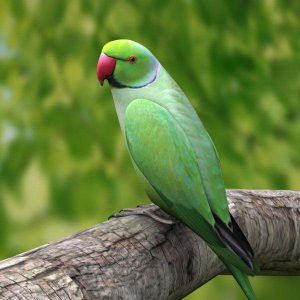

In [41]:
# Assuming you have your image as a PyTorch tensor (C x H x W)

# url = 'https://t3.ftcdn.net/jpg/05/57/73/24/360_F_557732439_jQDlg9VwJDR7sZOj2urhhAZhAJ03oJVR.jpg'
# url = 'https://i.pinimg.com/1200x/6a/48/be/6a48be32f5dbd8611971f1153b2f38dc.jpg'
url = 'https://i.pinimg.com/1200x/b2/f3/a8/b2f3a893435f74436e3bd8f1733a7d76.jpg'

image = Image.open(requests.get(url, stream=True).raw)
image



 ## Define untility functions

In [42]:


def horizontally_shuffle_image(image, n):
    # Get the width and height of the image
    width, height = image.size

    # Calculate the width of each chopped piece
    chopped_width = width // n

    # To store the chopped pieces
    chopped_pieces = []

    # Chop the image horizontally into 'n' pieces
    for i in range(n):
        left = i * chopped_width
        right = left + chopped_width
        box = (left, 0, right, height)
        chopped_piece = image.crop(box)
        chopped_pieces.append(chopped_piece)

    # Shuffle the chopped pieces
    random.shuffle(chopped_pieces)

    # Create a new image by horizontally shuffling the pieces
    shuffled_image = Image.new('RGB', (width, height))
    x_offset = 0
    for piece in chopped_pieces:
        shuffled_image.paste(piece, (x_offset, 0))
        x_offset += chopped_width

    return shuffled_image



def vertically_shuffle_image(image, n):
    # Get the width and height of the image
    width, height = image.size

    # Calculate the height of each chopped piece
    chopped_height = height // n

    # To store the chopped pieces
    chopped_pieces = []

    # Chop the image vertically into 'n' pieces
    for i in range(n):
        top = i * chopped_height
        bottom = top + chopped_height
        box = (0, top, width, bottom)
        chopped_piece = image.crop(box)
        chopped_pieces.append(chopped_piece)

    # Shuffle the chopped pieces
    random.shuffle(chopped_pieces)

    # Create a new image by vertically shuffling the pieces
    shuffled_image = Image.new('RGB', (width, height))
    y_offset = 0
    for piece in chopped_pieces:
        shuffled_image.paste(piece, (0, y_offset))
        y_offset += chopped_height

    return shuffled_image



def diagonally_shuffle_image(image, n):
    # Get the width and height of the image
    width, height = image.size

    # Calculate the dimensions of each chopped piece
    chopped_width = width // n
    chopped_height = height // n

    # To store the chopped pieces
    chopped_pieces = []

    # Chop the image diagonally into 'n' pieces
    for i in range(n):
        left = i * chopped_width
        top = i * chopped_height
        right = left + chopped_width
        bottom = top + chopped_height
        box = (left, top, right, bottom)
        chopped_piece = image.crop(box)
        chopped_pieces.append(chopped_piece)

    # Shuffle the chopped pieces
    random.shuffle(chopped_pieces)

    # Create a new image by diagonally shuffling the pieces
    shuffled_image = Image.new('RGB', (width, height))
    x_offset, y_offset = 0, 0
    for piece in chopped_pieces:
        shuffled_image.paste(piece, (x_offset, y_offset))
        x_offset += chopped_width
        y_offset += chopped_height

    return shuffled_image




def checkerboard_shuffle_image(image, n):
    # Get the width and height of the image
    width, height = image.size

    # Calculate the dimensions of each chopped piece
    chopped_width = width // n
    chopped_height = height // n

    # To store the chopped pieces
    chopped_pieces = []

    # Chop the image into 'n x n' grid of pieces
    for i in range(n):
        for j in range(n):
            left = i * chopped_width
            top = j * chopped_height
            right = left + chopped_width
            bottom = top + chopped_height
            box = (left, top, right, bottom)
            chopped_piece = image.crop(box)
            chopped_pieces.append(chopped_piece)

    # Shuffle the chopped pieces
    random.shuffle(chopped_pieces)

    # Create a new image by shuffling the pieces in an 'n x n' grid
    shuffled_image = Image.new('RGB', (width, height))
    x_offset, y_offset = 0, 0
    for piece in chopped_pieces:
        shuffled_image.paste(piece, (x_offset, y_offset))
        x_offset += chopped_width
        if x_offset >= width:
            x_offset = 0
            y_offset += chopped_height

    return shuffled_image



# Plot all in one place
def plot_images(images, n=5):
    fig, axes = plt.subplots(1, n, figsize=(12, 6))

    for i in range(n):
        if isinstance(images[i], Image.Image):
            axes[i].imshow(images[i])
            axes[i].axis('off')
        else:
            # Assuming the input is a PyTorch tensor with the shape (C, H, W)
            image = Image.fromarray(images[i].permute(1, 2, 0).cpu().numpy())
            axes[i].imshow(image)
            axes[i].axis('off')

    plt.show()


# To call ViT and see predctions and top 5 scores
def classify_image(image_path_or_pixels):
    # Preprocess the image
    inputs = processor(images=image_path_or_pixels, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values

    # Get the model logits
    with torch.no_grad():
        outputs = model(pixel_values)
    logits = outputs.logits

    # Get the prediction and probabilities
    prediction = logits.argmax(-1)
    predicted_class = model.config.id2label[prediction.item()]

    probabilities = F.softmax(logits, dim=-1)
    confidence = probabilities[0, prediction].item()

    top5_probabilities, top5_class_indices = torch.topk(probabilities, k=5, dim=-1)
    top5_probabilities = top5_probabilities[0].tolist()
    top5_class_indices = top5_class_indices[0].tolist()

    top5_results = []
    for i, class_idx in enumerate(top5_class_indices):
        class_label = model.config.id2label[class_idx]
        confidence_class = top5_probabilities[i]
        top5_results.append((class_label, confidence_class ))

    return predicted_class, confidence, top5_results



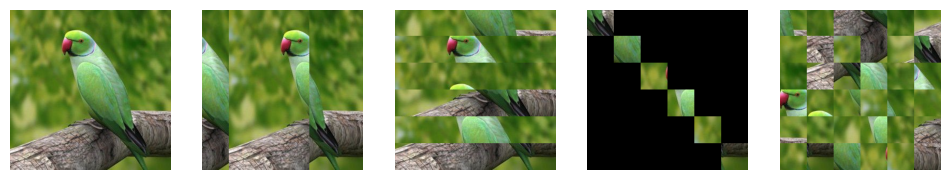

In [43]:
n = 6
horizontally_shuffled_image = horizontally_shuffle_image(image, n)
vertically_shuffled_image = vertically_shuffle_image(image, n)
diagonally_shuffled_image = diagonally_shuffle_image(image, n)
checkerboard_shuffle_image = checkerboard_shuffle_image(image, n)


plot_images([image, horizontally_shuffled_image, vertically_shuffled_image, diagonally_shuffled_image , checkerboard_shuffle_image],5)



## Load the pre-trained model and image processor

In [44]:
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
processor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

model.to(device)


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

## Prediction for the image

In [45]:
predicted_class, confidence, top5_results = classify_image(image)

print("Predicted class:", predicted_class)
print("Confidence:", confidence)
print("Top 5 Results:")
for i, (class_label, conf) in enumerate(top5_results):
    print(f"{i + 1}. {class_label}: {conf:.2f}")

Predicted class: macaw
Confidence: 0.17200012505054474
Top 5 Results:
1. macaw: 0.17
2. lorikeet: 0.14
3. jacamar: 0.08
4. bee eater: 0.04
5. sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita: 0.04


## Repeating the same thing for **horizontally shuffled** image


In [46]:
predicted_class, confidence, top5_results = classify_image(horizontally_shuffled_image)

print("Predicted class:", predicted_class)
print("Confidence:", confidence)
print("Top 5 Results:")
for i, (class_label, conf) in enumerate(top5_results):
    print(f"{i + 1}. {class_label}: {conf:.2f}")

Predicted class: macaw
Confidence: 0.2937262952327728
Top 5 Results:
1. macaw: 0.29
2. lorikeet: 0.15
3. sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita: 0.05
4. toucan: 0.03
5. African grey, African gray, Psittacus erithacus: 0.03


## Repeating the same thing for **verticaly shuffled** image

In [47]:
predicted_class, confidence, top5_results = classify_image(vertically_shuffled_image)

print("Predicted class:", predicted_class)
print("Confidence:", confidence)
print("Top 5 Results:")
for i, (class_label, conf) in enumerate(top5_results):
    print(f"{i + 1}. {class_label}: {conf:.2f}")

Predicted class: macaw
Confidence: 0.1915762722492218
Top 5 Results:
1. macaw: 0.19
2. lorikeet: 0.11
3. toucan: 0.05
4. sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita: 0.05
5. green mamba: 0.03



## Repeating the same thing for **diagonally shuffled** image

In [48]:
predicted_class, confidence, top5_results = classify_image(diagonally_shuffled_image)

print("Predicted class:", predicted_class)
print("Confidence:", confidence)
print("Top 5 Results:")
for i, (class_label, conf) in enumerate(top5_results):
    print(f"{i + 1}. {class_label}: {conf:.2f}")

Predicted class: macaw
Confidence: 0.4520862102508545
Top 5 Results:
1. macaw: 0.45
2. lorikeet: 0.21
3. jacamar: 0.08
4. bee eater: 0.07
5. vine snake: 0.03


## Repeating the same thing for **checkerboard shuffled** image


In [49]:
predicted_class, confidence, top5_results = classify_image(checkerboard_shuffle_image)

print("Predicted class:", predicted_class)
print("Confidence:", confidence)
print("Top 5 Results:")
for i, (class_label, conf) in enumerate(top5_results):
    print(f"{i + 1}. {class_label}: {conf:.2f}")

Predicted class: lorikeet
Confidence: 0.1214507445693016
Top 5 Results:
1. lorikeet: 0.12
2. green mamba: 0.11
3. vine snake: 0.11
4. macaw: 0.08
5. bee eater: 0.04


In [50]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
inputs = processor(images= checkerboard_shuffle_image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values
print(pixel_values.shape)


with torch.no_grad():
  outputs = model(pixel_values)
logits = outputs.logits
print(logits.shape)


prediction = logits.argmax(-1)
print("Predicted class:", model.config.id2label[prediction.item()])


probabilities = F.softmax(logits, dim=-1)
confidence = probabilities[0, prediction].item()
top5_probabilities, top5_class_indices = torch.topk(probabilities, k=5, dim=-1)

top5_probabilities = top5_probabilities[0].tolist()
top5_class_indices = top5_class_indices[0].tolist()

for i, class_idx in enumerate(top5_class_indices):
    class_label = model.config.id2label[class_idx]
    confidence = top5_probabilities[i]
    print(f"{i + 1}. {class_label}: {confidence:.2f}")

torch.Size([1, 3, 224, 224])
torch.Size([1, 1000])
Predicted class: lorikeet
1. lorikeet: 0.12
2. green mamba: 0.11
3. vine snake: 0.11
4. macaw: 0.08
5. bee eater: 0.04
